# Inducible promoter (Hill activation by ligand $L(t)$)

### $$\dot{m} = k_{tx}\frac{L^n}{K^n + L^n} - (\gamma_m+\mu)m$$
### $$\dot{p} =  k_{tl}m - (\gamma_p + \mu)p$$

#### Hyperparameters
##### $k_{tx} [mRNA · time^{−1}]$ — transcription rate.
##### $k_{tl} [(protein).mRNA · time^{−1}]$ - translation rate.
##### $γm[time−1]$ — mRNA decay rate
##### $γp[time−1]$ — protein decay rate
##### $μ [time−1]$ — growth/dilution rate (set 0 for non-growing cells or include to see how growth throttles levels)

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import mplhelv

### $$
\text { Instant step at } t_0: L(t)= \begin{cases}L_0, & t<t_0 \\ L_1, & t \geq t_0\end{cases}
$$

In [2]:
def Lfunc(t, t0=0.0, L0=0.0, L1=1.0):
    ta = np.asarray(t)
    out = np.where(ta < t0, L0, L1)
    return float(out) if np.isscalar(t) else out

### $$
 \text { Smooth Step } L(t)= L_0 + (L_1 - L_0)\frac{1}{1+e^{\frac{-(t-t_0)}{\tau}}}
$$

In [3]:
def Lsmooth(t, t0=0.0, L0=0.0, L1=1.0, tau=1e-3):
    ta = np.asarray(t)
    s = 1.0/(1.0 + np.exp(-(ta - t0)/tau))
    out = L0 + (L1 - L0)*s
    return float(out) if np.isscalar(t) else out

In [4]:
def genex(t, mp, params):
    ktx, gammam, mu, ktl, gammap, l, K, n, t0 = params
    m, p = mp
    L = l(t, t0=t0)
    hill = L**n/(K**n + L**n)
    hill = hill if hill > 0 else 0
    return [ktx*hill - (gammam + mu)*m, ktl*m - (gammap + mu)*p]

In [5]:
time = (0, 10)

K=0.5 #(half-activation mid-range)
n=2
ktx=1
gammam=1
ktl=5
gammap=0.2
mu=0
m0=0 
p0=0
t0 = 0
l = Lfunc
params = (ktx, gammam, mu, ktl, gammap, l, K, n, t0)

In [6]:
m_star = ktx/(gammam + mu)
p_star = (ktl*m_star)/(gammap + mu)
tau_m = 1.0/(gammam + mu)
tau_p = 1.0/(gammap + mu)

In [8]:
t = np.linspace(*time, 4000)

## With l(t) following the step function, sweep for n

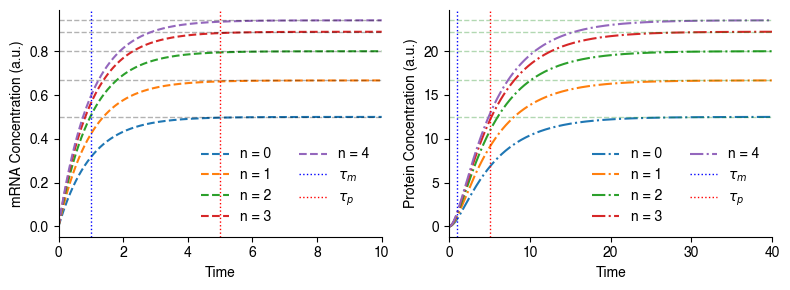

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for n in range(5):
    t0 = 0
    time = (0, 40)
    params = (ktx, gammam, mu, ktl, gammap, Lfunc, K, n, t0)

    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label=f'n = {n}')
    axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')
    A_inf = (1.0**n)/(K**n + 1.0**n)  # adjust if you change L1
    m_star = (ktx*A_inf)/(gammam + mu)
    p_star = (ktl*m_star)/(gammap + mu)
    axs[0].axhline(m_star, color='k', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].axhline(p_star, color='g', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 40)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.axvline(tau_m, color='b', linestyle=':', linewidth=1, label=r'$\tau_m$')
    ax.axvline(tau_p, color='r', linestyle=':', linewidth=1, label=r'$\tau_p$')
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

## With l(t) following the step function, sweep for $t_0$

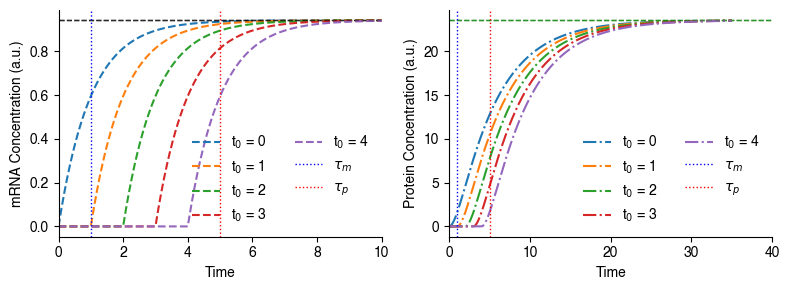

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for t0 in range(5):
    time = (0, 35)
    params = (ktx, gammam, mu, ktl, gammap, Lfunc, K, n, t0)

    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label='t'+r'$_0$'+' = '+f'{t0}')
    axs[1].plot(t, pdot, ls='-.', label='t'+r'$_0$'+' = '+f'{t0}')
    A_inf = (1.0**n)/(K**n + 1.0**n)  # adjust if you change L1
    m_star = (ktx*A_inf)/(gammam + mu)
    p_star = (ktl*m_star)/(gammap + mu)
    axs[0].axhline(m_star, color='k', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].axhline(p_star, color='g', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 40)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.axvline(tau_m, color='b', linestyle=':', linewidth=1, label=r'$\tau_m$')
    ax.axvline(tau_p, color='r', linestyle=':', linewidth=1, label=r'$\tau_p$')
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

## With l(t) following the smooth function, sweep for n

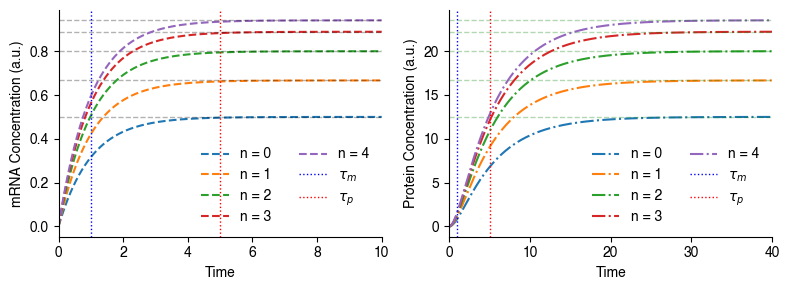

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for n in range(5):
    t0 = 0
    time = (0, 40)
    params = (ktx, gammam, mu, ktl, gammap, Lsmooth, K, n, t0)

    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label=f'n = {n}')
    axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')
    A_inf = (1.0**n)/(K**n + 1.0**n)  # adjust if you change L1
    m_star = (ktx*A_inf)/(gammam + mu)
    p_star = (ktl*m_star)/(gammap + mu)
    axs[0].axhline(m_star, color='k', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].axhline(p_star, color='g', linestyle='--', linewidth=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 40)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.axvline(tau_m, color='b', linestyle=':', linewidth=1, label=r'$\tau_m$')
    ax.axvline(tau_p, color='r', linestyle=':', linewidth=1, label=r'$\tau_p$')
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

## Phase plane with nullclines

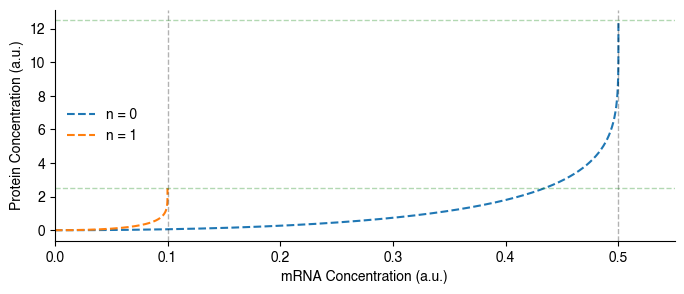

In [70]:
fig, axs = plt.subplots(figsize=(8, 3))
for n in range(2):
    t0 = 0
    time = (0, 40)
    params = (ktx, gammam, mu, ktl, gammap, Lsmooth, K, n, t0)

    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs.plot(mdot, pdot, ls='--', label=f'n = {n}')
    A_inf = (1.0**n)/(K**n + 1.0**n)  # adjust if you change L1
    m_star = (ktx*A_inf)/(gammam + mu)
    p_star = (ktl*m_star)/(gammap + mu)
    axs.axvline(m_star, color='k', linestyle='--', linewidth=1, alpha=0.3)
    axs.axhline(p_star, color='g', linestyle='--', linewidth=1, alpha=0.3)
    axs.set_xlabel("mRNA Concentration (a.u.)")
    axs.set_ylabel("Protein Concentration (a.u.)")
    axs.legend(frameon = False)
    axs.spines[["top", "right"]].set_visible(False)
    axs.set_xlim(0, 0.55)
    # axs.set_ylim(0, 12)

## steady p over a grid like (K,L) or (μ,L). Growth-vs-Expression tradeoffs.

(0.0, 4.0)

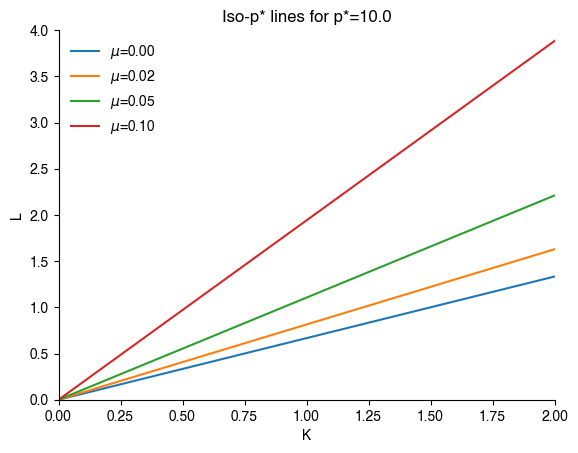

In [79]:
mus = [0.0, 0.02, 0.05, 0.1]     # growth rates to compare
p_tar = 10.0                     # desired steady protein
K_grid = np.linspace(0.01, 2.0, 200)
for mu_i in mus:
    G = (ktx*ktl) / ((gammam+mu_i)*(gammap+mu_i))
    A_tar = p_tar / G
    if 0 < A_tar < 1:
        s = (A_tar/(1-A_tar))**(1/n)
        L_line = s * K_grid
        plt.plot(K_grid, L_line, label=r'$\mu$'+f"={mu_i:.2f}")
plt.xlabel("K")
plt.ylabel("L")
plt.legend(frameon=False)
plt.title(f"Iso-p* lines for p*={p_tar}")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.xlim(0, 2)
plt.ylim(0, 4)